In [11]:
#Dataset: https://www.kaggle.com/arjuntejaswi/plant-village

In [140]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [28]:
Image_size = 256
Batch_size = 32
channels = 3
epochs = 25

In [ ]:
# Import data into tensorflow dataset object

In [79]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("C:/Users\srupa\Downloads\potato disease", shuffle = True, image_size = (Image_size, Image_size),batch_size = Batch_size)

Found 2146 files belonging to 3 classes.


In [119]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [81]:

 len(dataset)  ## 32 batches of images so the size is 68

68

In [82]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())  
## printing the shape of the images present in 1 batch with label(classes:0,1,2)
# 32 images of size 256*256 with 3 channel

(32, 256, 256, 3)
[0 1 0 1 2 1 1 1 1 1 0 0 2 0 0 2 0 1 1 1 1 2 1 1 0 1 1 0 1 0 1 0]


In [ ]:
# As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images.
#Second element is a batch of 32 elements of class labels


In [ ]:
## visualizing the some of the images from the dataset

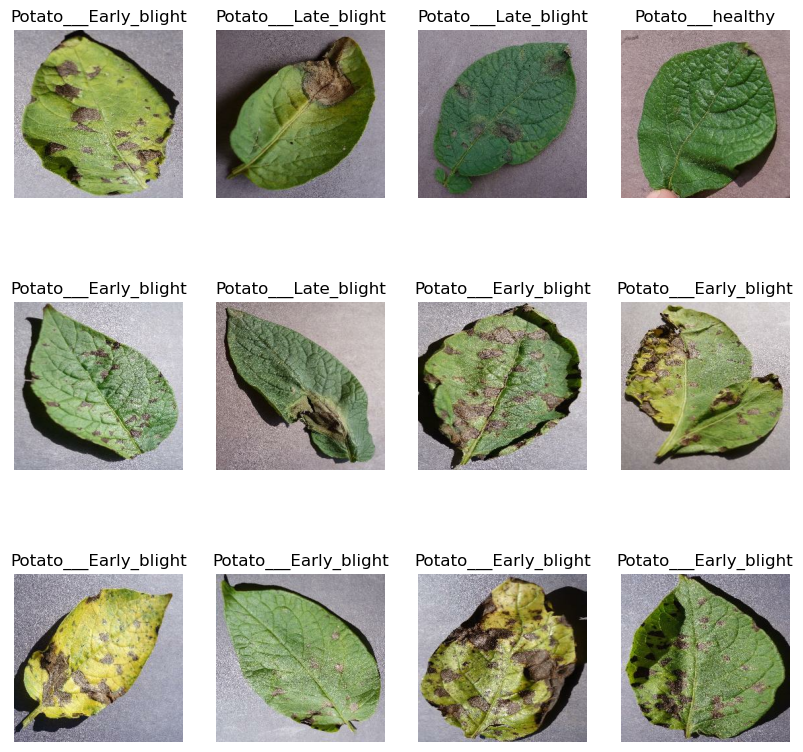

In [83]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1): # 1batch is taken
    for i in range(12):
        ax = plt.subplot(3,4,i+1)  ## row 3, column 4 and the each image index is given bi i+1
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

## Splitting data 

In [84]:
80% ==> training
20% ==> 10% validation , 10% test

SyntaxError: invalid syntax (3470375362.py, line 1)

In [85]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds



In [86]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [87]:
len(train_ds)

54

In [88]:
len(val_ds)

6

In [89]:
len(test_ds)

8

In [ ]:
# # catche, shuffle, and prefetch the dataset

In [108]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
train_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
'''Building the Model

Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance,
we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while 
training as well as inference.
Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't
need to but this will be useful when we are done with the training and start using the model for predictions. 
At that time somone can supply an image that is not (256,256) and this layer will resize it'''


In [91]:
# data preprocessing, data augumentation
## normalization the data by dividing by 255
resize_rescale = tf.keras.Sequential([layers.experimental.preprocessing.Resizing(Image_size,Image_size), 
                    layers.experimental.preprocessing.Rescaling(1.0/255)])

In [92]:
## data augmentation is needed when we have less data , it boosts the accuracy 
data_augumentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                         layers.experimental.preprocessing.RandomRotation(0.2)])

In [137]:
# applying data augumentation to training data 
train_ds = train_ds.map(
    lambda x, y: (data_augumentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
''' model architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers 
for resizing, normalization and Data Augmentation.'''

In [93]:
input_shape = (Batch_size, Image_size, Image_size, channels)
n_classes = 3
model = models.Sequential([resize_rescale,
                         data_augumentation,
                         layers.Conv2D(32,(3,3), activation = "relu", input_shape = input_shape),
                         layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,kernel_size = (3,3), activation = "relu"),
                         layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,kernel_size = (3,3), activation = "relu"),
                         layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,kernel_size = (3,3), activation = "relu"),
                         layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,kernel_size = (3,3), activation = "relu"),
                         layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,kernel_size = (3,3), activation = "relu"),
                         layers.MaxPooling2D((2,2)),
                         layers.Flatten(),
                         layers.Dense(64, activation = 'relu'),
                         layers.Dense(n_classes, activation = "softmax")])
model.build(input_shape = input_shape)

In [94]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_8 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_19 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_19 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [ ]:
## compiling the model 
#used Adam optimizer,SparseCategoricalCrossentropy for losses , accuracy as a metric

In [97]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer = optimizer, loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
             metrics = ['accuracy'])

In [96]:

history = model.fit(train_ds, epochs = epochs, batch_size = 32, verbose = 1, validation_data = val_ds)

Epoch 1/25
8/8 [==============================] - 22s 2s/step - loss: 0.9653 - accuracy: 0.4414 - val_loss: 0.9208 - val_accuracy: 0.4479
Epoch 2/25
8/8 [==============================] - 13s 2s/step - loss: 0.8661 - accuracy: 0.4531 - val_loss: 0.9035 - val_accuracy: 0.4948
Epoch 3/25
8/8 [==============================] - 13s 2s/step - loss: 0.8807 - accuracy: 0.4688 - val_loss: 0.8807 - val_accuracy: 0.5000
Epoch 4/25
8/8 [==============================] - 14s 2s/step - loss: 0.8482 - accuracy: 0.4766 - val_loss: 0.8772 - val_accuracy: 0.4219
Epoch 5/25
8/8 [==============================] - 14s 2s/step - loss: 0.8456 - accuracy: 0.5664 - val_loss: 0.8832 - val_accuracy: 0.4688
Epoch 6/25
8/8 [==============================] - 14s 2s/step - loss: 0.8278 - accuracy: 0.5508 - val_loss: 0.8623 - val_accuracy: 0.6250
Epoch 7/25
8/8 [==============================] - 14s 2s/step - loss: 0.7918 - accuracy: 0.7227 - val_loss: 0.7977 - val_accuracy: 0.6875
Epoch 8/25
8/8 [==================

In [99]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

In [ ]:
#3 plotting Accuracy and loss curves

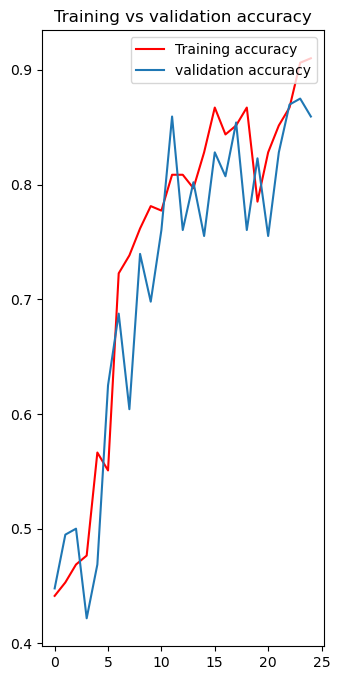

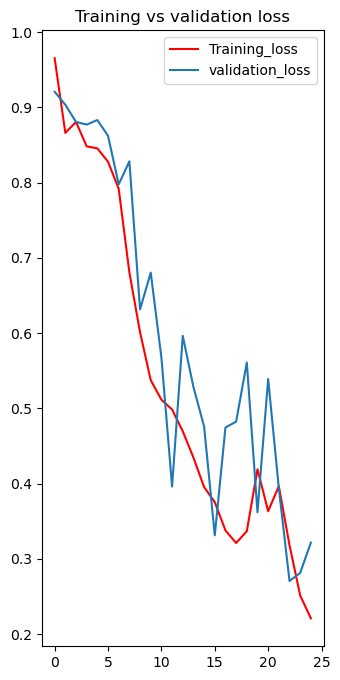

In [104]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs),acc, label = "Training accuracy", color = "red")
plt.plot(range(epochs), val_acc, label = "validation accuracy")
plt.title("Training vs validation accuracy")
plt.legend(loc = "upper right")


plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), loss, label = "Training_loss", color = "red")
plt.plot(range(epochs), val_loss, label = "validation_loss")
plt.title("Training vs validation loss")
plt.legend(loc = "upper right")

In [ ]:
## prediction on a test image 

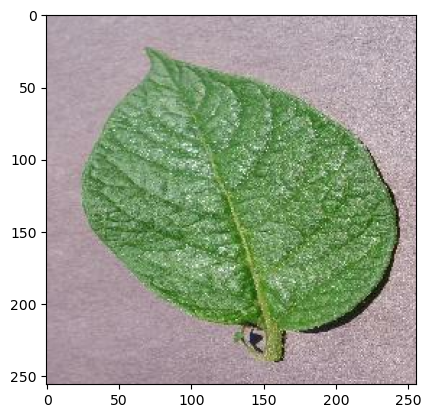

In [106]:
for image_batch, labels_batch in test_ds.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    

First image to predict
actual label: Potato___healthy
1/1 [==============================] - 0s 324ms/step
predicted label: Potato___healthy


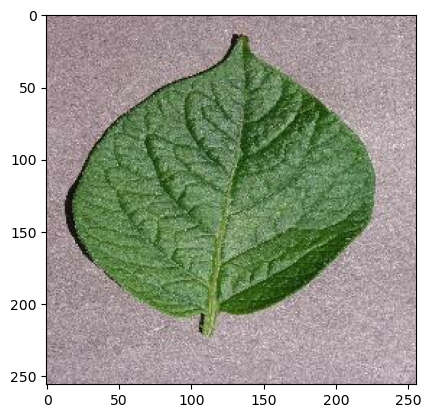

In [134]:
## checking the actual label and predicted label
for image_batch, label_batch in test_ds.take(1):
    
    first_img = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_img)
    
    print('actual label:', class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print('predicted label:', class_names[np.argmax(batch_prediction[0])])

In [138]:
 def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence




1/1 [==============================] - 0s 36ms/step


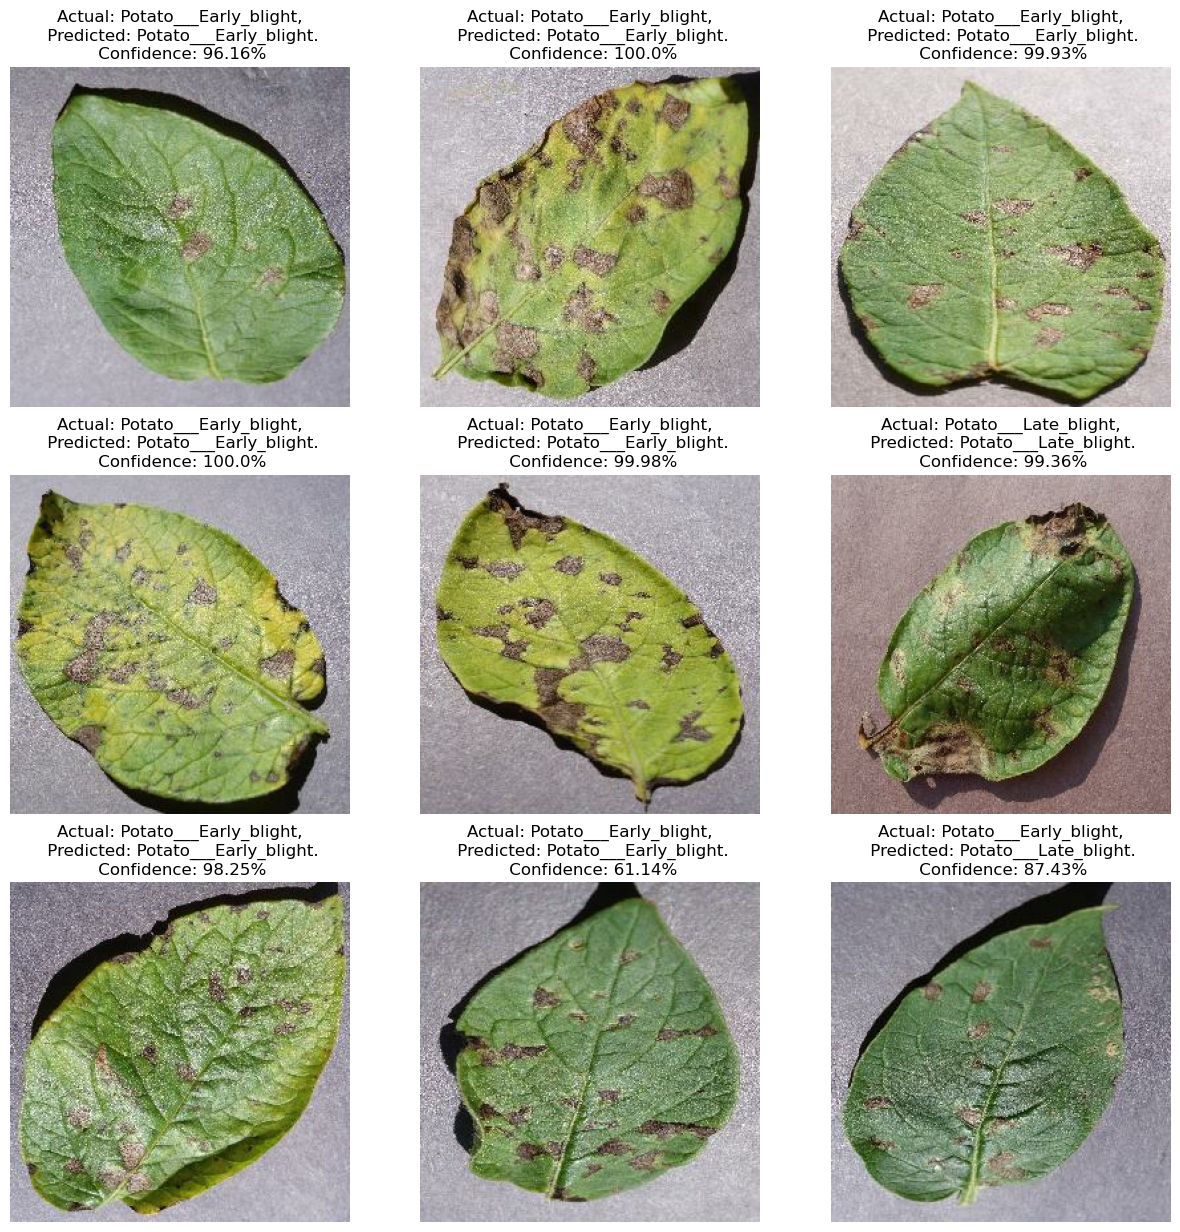

In [139]:
  plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [ ]:
## the comfidence level is good so saving the above model 

In [133]:
model_version = 1
model.save(f"../potato disease/{model_version}")

INFO:tensorflow:Assets written to: ../potato disease/1\assets


INFO:tensorflow:Assets written to: ../potato disease/1\assets


In [131]:
import os 
os.getcwd()

'C:\\Users\\srupa\\Downloads'